In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.constraints import *
from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.table.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
Meshcat url:  http://127.0.0.1:7005/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Set up grammar and constraint set.
pyro.set_rng_seed(42)
grammar = SpatialSceneGrammar(
    root_node_type = Table,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.0, 0., 0.8])),
    sample_params_from_prior=True
)
constraints = [
    ObjectsOnTableConstraint(),
    ObjectSpacingConstraint()
]

In [11]:
# Load dataset and draw an example from it
target_dataset_trees = []
with open("target_dataset_examples.pickle", "rb") as f:
    while 1:
        try:
            target_dataset_trees.append(pickle.load(f))
        except EOFError:
            break
print("Loaded %d environments" % len(target_dataset_trees))
observed_node_sets = [tree.get_observed_nodes() for tree in target_dataset_trees]
# NOTE: GT trees aren't perfect, as they're post-sim; their scores may be
# totally invalid.

ex_k = 5
draw_scene_tree_contents_meshcat(target_dataset_trees[ex_k], zmq_url=vis.window.zmq_url,  prefix="test_tree/contents")
draw_scene_tree_structure_meshcat(target_dataset_trees[ex_k], zmq_url=vis.window.zmq_url,  prefix="test_tree/structure",
                                  with_triad=False, linewidth=30, node_sphere_size=0.02)

Loaded 100 environments


In [5]:
# Do EM fitting process
em = EMWrapper(grammar, observed_node_sets, parsing_strategy="ip_noproposals", do_nlp_refinement=False)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=1, max_recursion_depth=10)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [6]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar.torch")
with open("fit_em.pickle", "wb") as fp:
    pickle.dump(em, fp)

# Plotting and inspection of EM fitting process

In [8]:
fit_grammar = SpatialSceneGrammar(
    root_node_type = Table,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
fit_grammar.load_state_dict(torch.load("fit_grammar.torch"))

gt_grammar = SpatialSceneGrammar(
    root_node_type = Table,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
gt_grammar.load_state_dict(torch.load("target_dataset_grammar_state_dict.torch"))

with open("fit_em.pickle", "rb") as fp:
    em = pickle.load(fp)

In [12]:
# Parse that earlier example
# Try to parse "tree" sampled above
# Parse it with IP.
vis["ip_parses"].delete()
supertree = fit_grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

observed_nodes = observed_node_sets[ex_k]
proposed_poses_by_type = generate_candidate_node_pose_sets(
    fit_grammar, observed_nodes, max_recursion_depth=10, verbose=True
)
parse_trees = infer_mle_tree_with_mip_from_proposals(
    fit_grammar, observed_nodes, {}, verbose=2, N_solutions=4
)
for k, parse_tree in enumerate(parse_trees):
    score = parse_tree.score()
    print("SOL #%d: SCORE %f" % (k, score))
    draw_scene_tree_structure_meshcat(parse_tree, zmq_url=vis.window.zmq_url, prefix="ip_parses/%d_%f" % (k, score),
                                      with_triad=False, linewidth=30, node_sphere_size=0.02, alpha=0.5)

Supertree size  88
18 top-down candidates.
18 bottom-up candidates.
Post final pruning:  36
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Wed Jan 19 18:31:13 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 376 rows, 175 columns and 823 nonzeros
Model fingerprint: 0xcb8c29b9
Variable types: 0 continuous, 175 integer (175 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [4e-01, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+00]
Presolve removed 369 rows and 160 columns
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 25 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Found heuristic solution: objective -77.4225651

Root relaxation: objective -7.742257e+01, 0 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

SOL #0: SCORE 77.422565
SOL #1: SCORE 72.856272
SOL #2: SCORE 69.230269
SOL #3: SCORE 64.663977


In [8]:
# Get scores for GT trees by parsing.
gt_tree_scores = []
for observed_nodes in tqdm(observed_node_sets):
    trees = infer_mle_tree_with_mip_from_proposals(
        gt_grammar, observed_nodes, {}, verbose=0, N_solutions=1, max_recursion_depth=10
    )
    gt_tree_scores.append(trees[0].score())

  0%|          | 0/100 [00:00<?, ?it/s]

Before:  -9564.49462782501 After:  8580.424762969571


Text(0.5, 1.0, 'Mean and std of scene log p(o)')

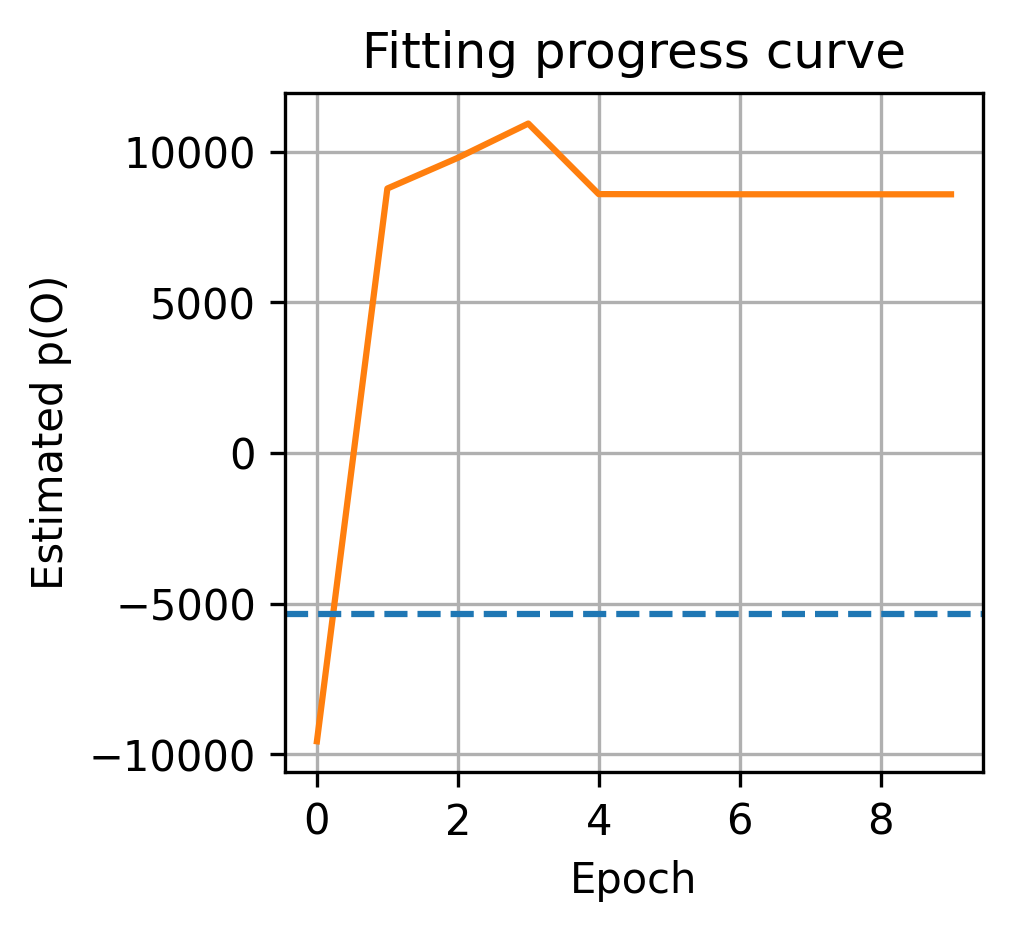

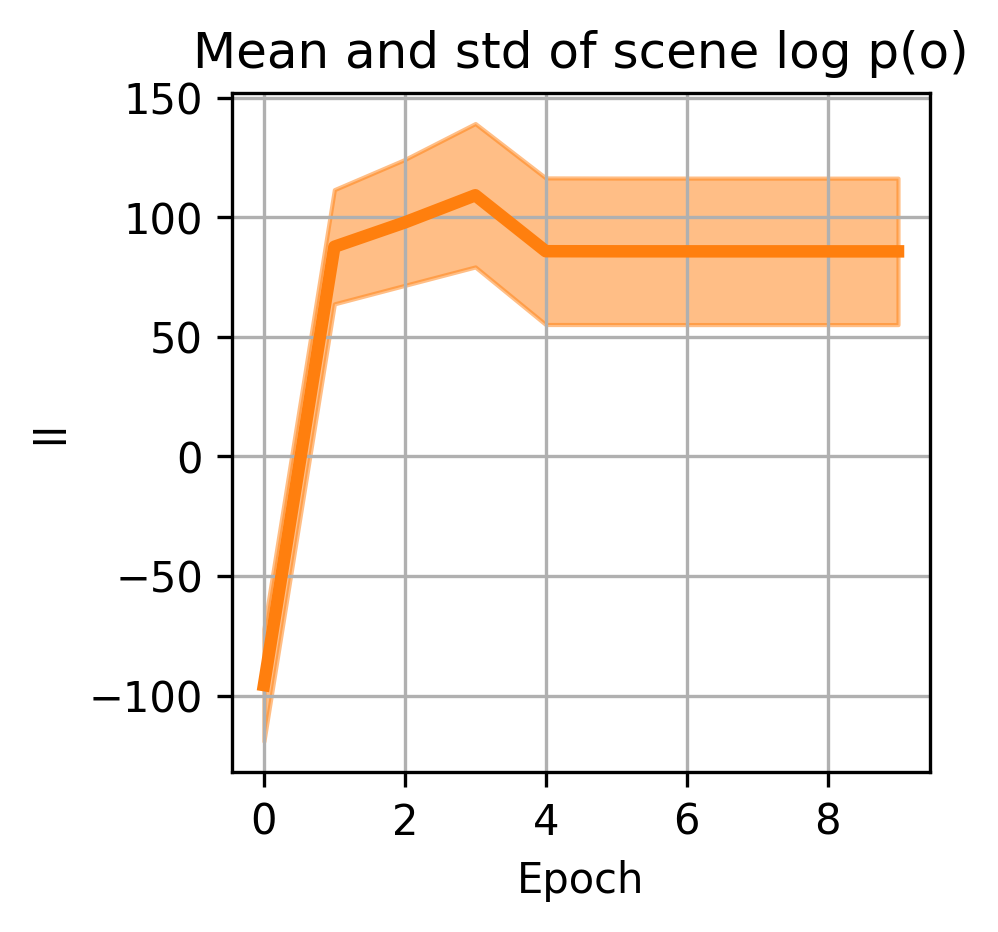

In [9]:
plt.figure(dpi=300).set_size_inches(3, 3)
totals = [np.sum(x) for x in em.log_evidence_iters]
plt.plot(totals, color="tab:orange")
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("Estimated p(O)")
plt.axhline(np.sum(gt_tree_scores), linestyle="--")
plt.title("Fitting progress curve")
print("Before: ", totals[0], "After: ", totals[-1])

# Slightly different: what's mean + avg p(o) for individual os look like?
plt.figure(dpi=300).set_size_inches(3, 3)
xs = range(len(em.log_evidence_iters))
means = np.array([np.mean(x) for x in em.log_evidence_iters])
stds = np.array([np.std(x) for x in em.log_evidence_iters])
plt.plot(xs, means, linewidth=3, color="tab:orange")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("ll")
plt.title("Mean and std of scene log p(o)")

In [10]:
# For each step over the fitting process, draw a population of samples from the
# candidate grammar, and collect the population of each terminal object type. Calculate
# MMDs against the corresponding populations of observed object types in the dataset.

# Precompute populations for dataset, and the dictionary we'll use to
# store the distance measurements.
observed_population_by_type = {}
for observed_nodes in observed_node_sets:
    for observed_node in observed_nodes:
        key = type(observed_node).__name__
        if key not in observed_population_by_type.keys():
            observed_population_by_type[key] = []
        observed_population_by_type[key].append(observed_node.tf)
for key, value in observed_population_by_type.items():
    observed_population_by_type[key] = torch.stack(value)

mmds_by_type = {key: [] for key in observed_population_by_type.keys()}

# For each EM iteration...
N_samples = 1000
mmd_alphas = [0.01, 0.05, 0.1, 0.5, 1.]
for k, grammar_state_dict in tqdm(enumerate(em.grammar_iters), total=len(em.grammar_iters)):
    grammar.load_state_dict(grammar_state_dict)
    # Build a population of observed nodes.
    sampled_population_by_type = {key: [] for key in observed_population_by_type.keys()}
    for k in range(N_samples):
        observed_nodes = grammar.sample_tree(detach=True).get_observed_nodes()
        for observed_node in observed_nodes:
            key = type(observed_node).__name__
            if key not in sampled_population_by_type:
                logging.warning("Sampled object not in observations: %s" % key)
                sampled_population_by_type[key] = []
            sampled_population_by_type[key].append(observed_node.tf)
    for key, value in sampled_population_by_type.items():
        sampled_population_by_type[key] = torch.stack(value)
    # Compute MMDs
    for key in observed_population_by_type.keys():
        observed_pop = observed_population_by_type[key]
        sampled_pop = sampled_population_by_type[key]
        if observed_pop.shape[0] > 0 and sampled_pop.shape[0] > 0:
            mmds_by_type[key].append(
                calculate_mmd(observed_pop, sampled_pop, alphas=mmd_alphas, use_se3_metric=True)
            )
        else:
            logging.warning("%d observed, %d sampled, can't compare." % (observed_pop.shape[0], sampled_pop.shape[0]))
            mmds_by_type[key].append(np.inf)

  0%|          | 0/11 [00:00<?, ?it/s]

Initial: 1.587796 +/- 0.253883
Final: -0.004546 +/- 0.012454


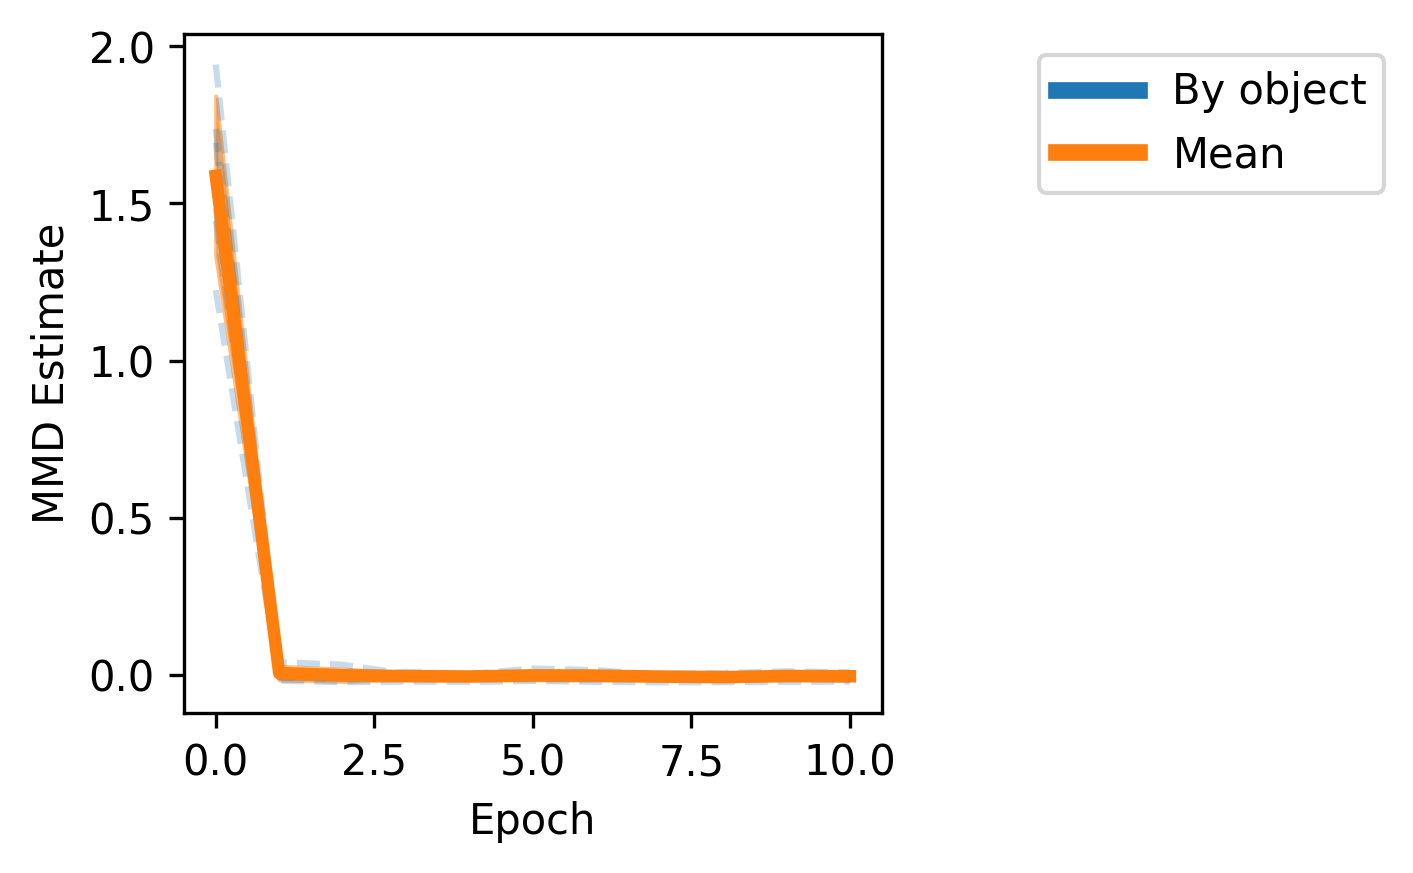

In [31]:
# Plot all of those over time.
plt.figure(dpi=300).set_size_inches(3, 3)

stacked_values = []
for key, value in mmds_by_type.items():
    if key == "Table":
        continue
    plt.plot(value, alpha=0.25, linestyle="--", c="tab:blue")
    stacked_values.append(torch.tensor(value))
stacked_values = torch.stack(stacked_values)
xs = range(stacked_values.shape[1])
means = torch.mean(stacked_values, dim=0)
stds = torch.std(stacked_values, dim=0)
plt.plot(xs, means, linewidth=3, color="tab:orange")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("MMD Estimate")
# Custom legend
from matplotlib.lines import Line2D
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_lines = [Line2D([0], [0], color="tab:blue", lw=4, label="By object"),
                Line2D([0], [0], color="tab:orange", lw=4, label="Mean")]
plt.gca().legend(handles=custom_lines, bbox_to_anchor=[1.75, 1])

initial_mmds = stacked_values[:, 0]
last_mmds = stacked_values[:, -1]
print("Initial: %f +/- %f" % (torch.mean(initial_mmds), torch.std(initial_mmds)))
print("Final: %f +/- %f" % (torch.mean(last_mmds), torch.std(last_mmds)))

Text(0.5, 1.0, 'Weights of child types of "PlaceSetting"\nduring EM process')

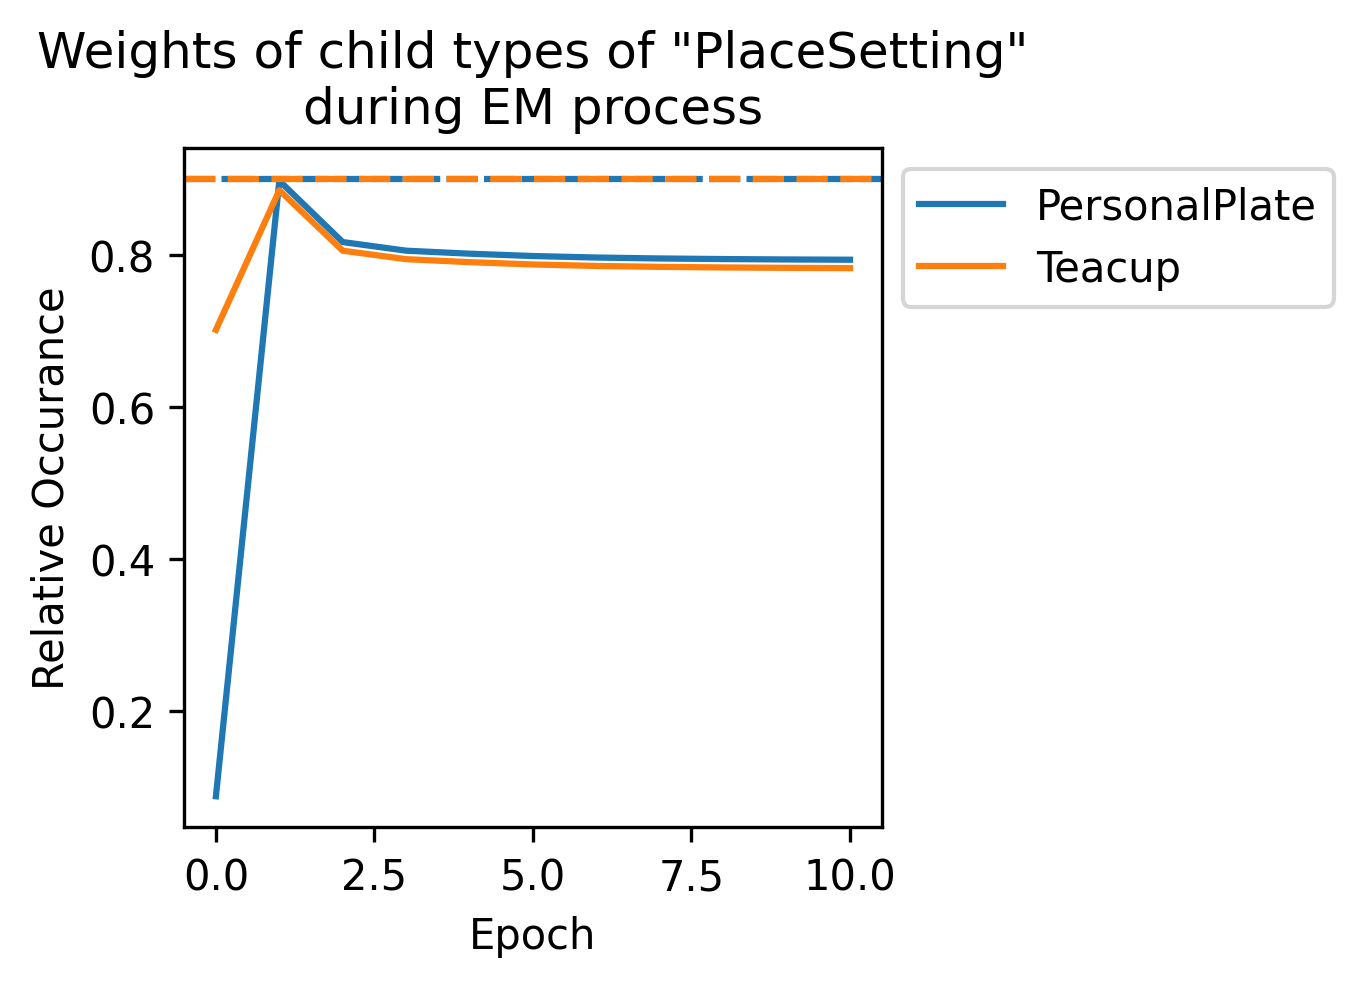

In [15]:
# Extract grammar history for PlaceSetting and label it appropriately
object_params_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    object_params_history.append(grammar.params_by_node_type["PlaceSetting"]().detach().numpy())
gt_params = gt_grammar.params_by_node_type["PlaceSetting"]().detach().numpy()
object_params_history = np.stack(object_params_history)
object_child_types = [rule.child_type.__name__ for rule in PlaceSetting.generate_rules()]
plt.figure(dpi=300).set_size_inches(3, 3)
for k, child_name in enumerate(object_child_types):
    stuff = plt.plot(object_params_history[:, k], label=child_name)
    plt.axhline(gt_params[k], linestyle="--", c=stuff[0].get_c(), dashes=(5, k+1))
    
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Epoch")
plt.ylabel("Relative Occurance")
plt.title("Weights of child types of \"PlaceSetting\"\nduring EM process")

[0. 0. 0.]
[0.25 0.   0.  ]


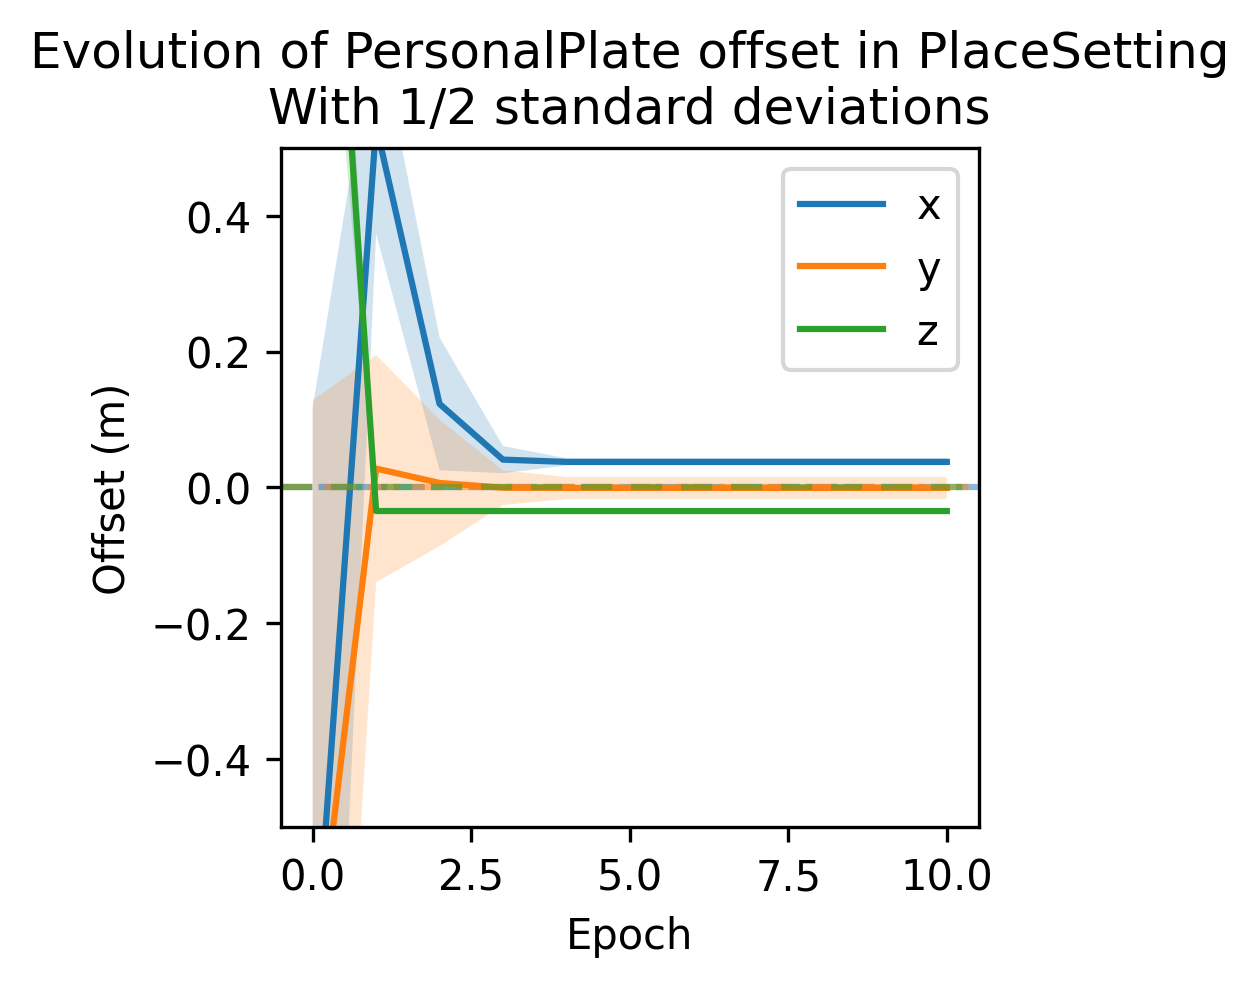

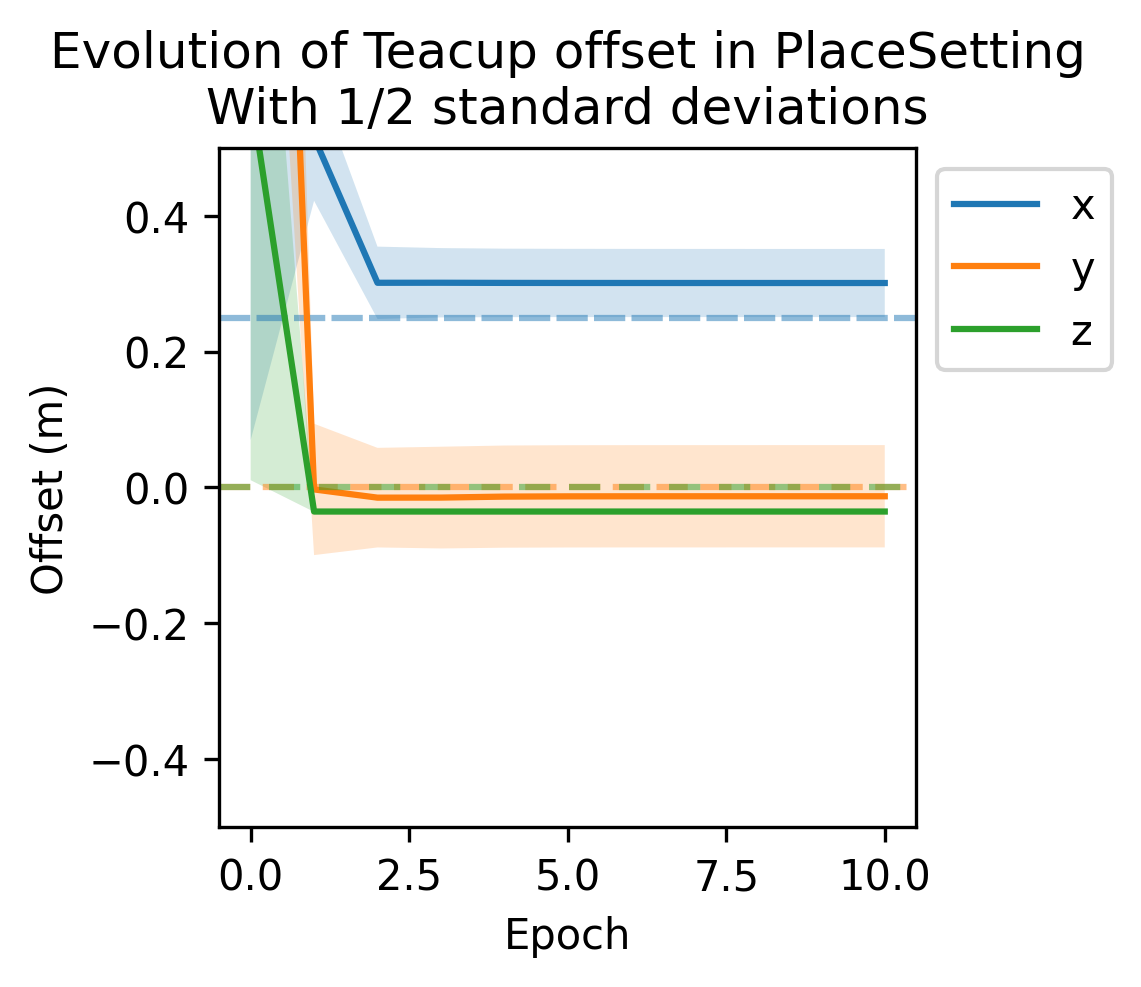

In [16]:
# Extract grammar history for PlaceSetting xyz offsets for each child
for rule_k, rule in enumerate(PlaceSetting.generate_rules()):

    t_mean_history = []
    t_var_history = []
    for grammar_state_dict in em.grammar_iters:
        grammar.load_state_dict(grammar_state_dict)
        t_mean_history.append(grammar.rule_params_by_node_type["PlaceSetting"][rule_k][0]["mean"]().detach().numpy().copy())
        t_var_history.append(grammar.rule_params_by_node_type["PlaceSetting"][rule_k][0]["variance"]().detach().numpy().copy())
    t_mean_history = np.stack(t_mean_history)
    t_var_history = np.stack(t_var_history)

    gt_t = gt_grammar.rule_params_by_node_type["PlaceSetting"][rule_k][0]["mean"]().detach().numpy()

    plt.figure(dpi=300).set_size_inches(3, 3)
    t_std_history = np.sqrt(t_var_history)*0.5
    for k in range(3):
        xs = range(t_mean_history.shape[0])
        thing = plt.plot(xs, t_mean_history[:, k], label="xyz"[k])
        plt.fill_between(xs, t_mean_history[:, k]-t_std_history[:, k], t_mean_history[:, k]+t_std_history[:, k], alpha=0.2)
        plt.axhline(gt_t[k], linestyle="--", c=thing[0].get_c(), alpha=0.5, dashes=(5, 1+k))

    plt.ylim(-0.5, 0.5)
    plt.xlabel("Epoch")
    plt.ylabel("Offset (m)")
    plt.legend(bbox_to_anchor=[1, 1])
    plt.title("Evolution of %s offset in PlaceSetting\nWith 1/2 standard deviations" % rule.child_type.__name__)
    print(gt_t)

[0.  0.  0.1]
[0.  0.  0.1]


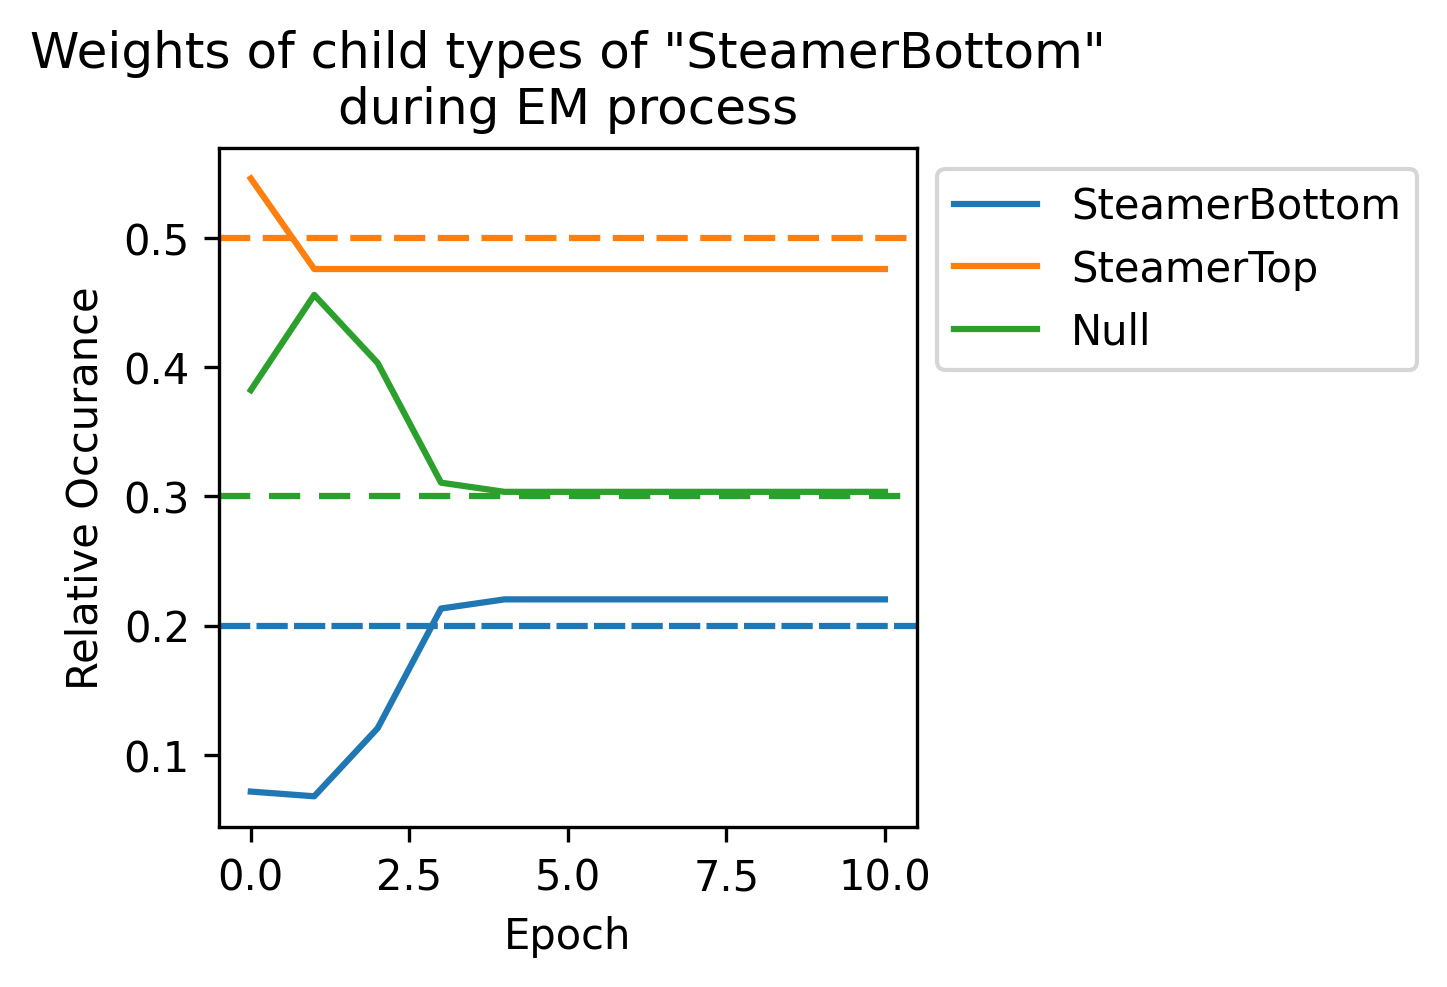

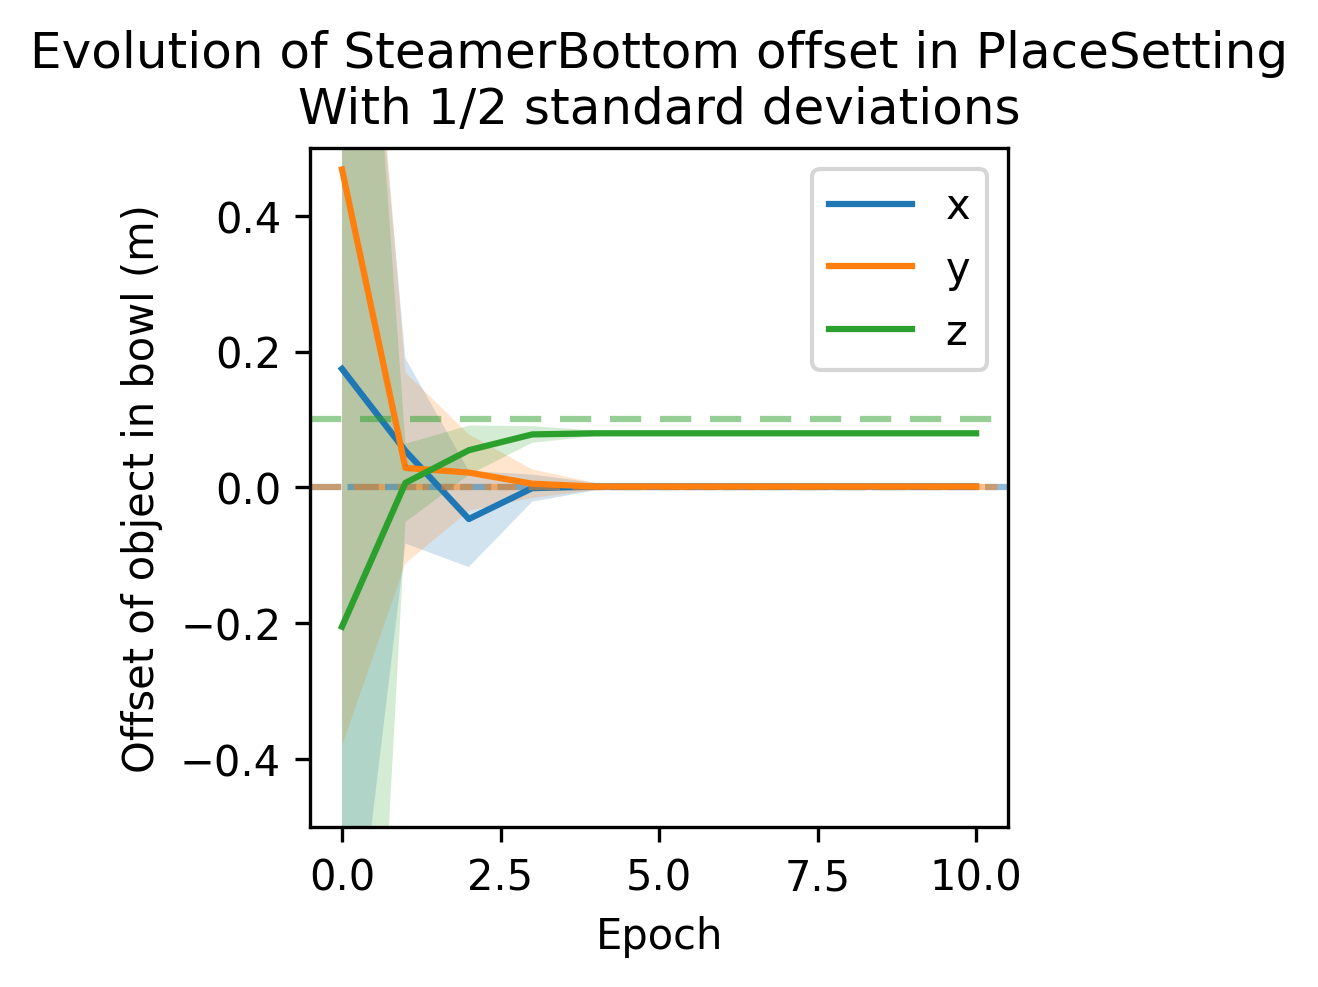

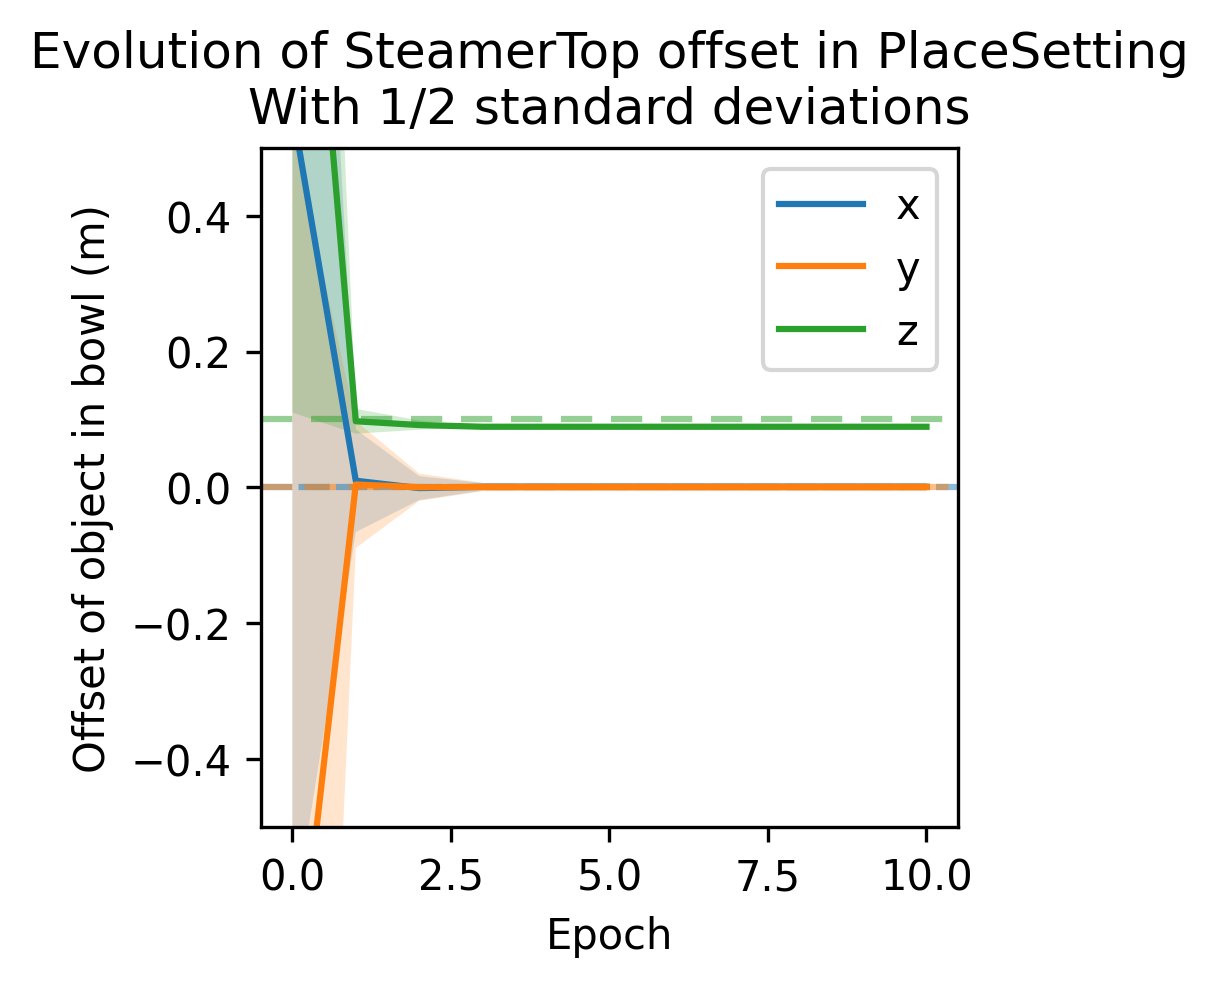

In [23]:
# Extract grammar history for SteamerBottom params + xyz offsets for first two (non-null) children

object_params_history = []
for grammar_state_dict in em.grammar_iters:
    grammar.load_state_dict(grammar_state_dict)
    object_params_history.append(grammar.params_by_node_type["SteamerBottom"]().detach().numpy())
gt_params = gt_grammar.params_by_node_type["SteamerBottom"]().detach().numpy()
object_params_history = np.stack(object_params_history)
object_child_types = [rule.child_type.__name__ for rule in SteamerBottom.generate_rules()]
plt.figure(dpi=300).set_size_inches(3, 3)
for k, child_name in enumerate(object_child_types):
    stuff = plt.plot(object_params_history[:, k], label=child_name)
    plt.axhline(gt_params[k], linestyle="--", c=stuff[0].get_c(), dashes=(5, 1+k))
plt.legend(bbox_to_anchor=[1, 1])
plt.xlabel("Epoch")
plt.ylabel("Relative Occurance")
plt.title("Weights of child types of \"SteamerBottom\"\nduring EM process")

for rule_k, rule in enumerate(SteamerBottom.generate_rules()[:2]):
    t_mean_history = []
    t_var_history = []
    for grammar_state_dict in em.grammar_iters:
        grammar.load_state_dict(grammar_state_dict)
        t_mean_history.append(grammar.rule_params_by_node_type["SteamerBottom"][rule_k][0]["mean"]().detach().numpy().copy())
        t_var_history.append(grammar.rule_params_by_node_type["SteamerBottom"][rule_k][0]["variance"]().detach().numpy().copy())
    t_mean_history = np.stack(t_mean_history)
    t_var_history = np.stack(t_var_history)

    gt_t = gt_grammar.rule_params_by_node_type["SteamerBottom"][rule_k][0]["mean"]().detach().numpy()

    plt.figure(dpi=300).set_size_inches(3, 3)
    t_std_history = np.sqrt(t_var_history)*0.5
    for k in range(3):
        xs = range(t_mean_history.shape[0])
        thing = plt.plot(xs, t_mean_history[:, k], label="xyz"[k])
        plt.fill_between(xs, t_mean_history[:, k]-t_std_history[:, k], t_mean_history[:, k]+t_std_history[:, k], alpha=0.2)
        plt.axhline(gt_t[k], linestyle="--", c=thing[0].get_c(), alpha=0.5, dashes=(5, 1+k))

    plt.ylim(-0.5, 0.5)
    plt.xlabel("Epoch")
    plt.ylabel("Offset of object in bowl (m)")
    plt.legend(bbox_to_anchor=[1, 1])
    plt.title("Evolution of %s offset in PlaceSetting\nWith 1/2 standard deviations" % rule.child_type.__name__)
    print(gt_t)